#**Package**

In [584]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import collections, time

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, roc_curve,roc_auc_score, precision_score, recall_score,f1_score, make_scorer, accuracy_score
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

#**Seoul Bike Data**

## **Data Processing**

In [585]:
sb_ds = pd.read_csv("/content/SeoulBikeData.csv",encoding='latin1') 
sb_ds.head(3) 
# view the data

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [586]:
#Drop 3 columns date, Rented Bike Count and Hour
X = sb_ds.iloc[:, 2:-1].values 
y = sb_ds.iloc[:, -1].values
X[0],y

(array([0, -5.2, 37, 2.2, 2000, -17.6, 0.0, 0.0, 0.0, 'Winter',
        'No Holiday'], dtype=object),
 array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype=object))

In [587]:
# Encoding the X and Y
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1,-2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
le = LabelEncoder()
y = le.fit_transform(y)

In [588]:
sc = StandardScaler()
X = sc.fit_transform(X)
X[0],y, X.shape

(array([-0.22775689,  0.22775689, -0.57629575, -0.58051386, -0.58051386,
         1.74801475, -1.66132477, -1.51395724, -1.04248288,  0.45847578,
         0.92587135, -1.65960467, -0.65513172, -0.13179988, -0.17189109]),
 array([1, 1, 1, ..., 1, 1, 1]),
 (8760, 15))

## **K-Means**

###**K-means**

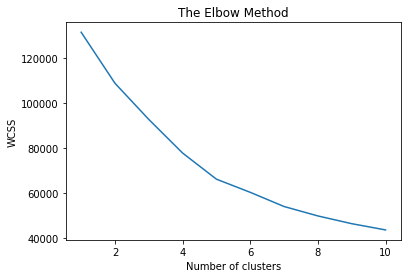

In [589]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [590]:
# choose 5 clusters
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
sb_ds['clusters1'] = y_kmeans # add cluster to the original dateset
collections.Counter(y_kmeans)

Counter({0: 2136, 1: 2160, 2: 1973, 3: 2059, 4: 432})

In [591]:
# before selection Kmeans Silhouette Score
s = silhouette_score(X, kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.3217450731277772


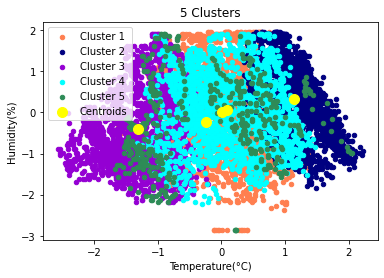

In [592]:
# Use Temperature and Humidity show 5 cluster 
plt.scatter(X[y_kmeans == 0, 7], X[y_kmeans == 0, 8], s = 20, c = 'coral', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 7], X[y_kmeans == 1, 8], s = 20, c = 'navy', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 7], X[y_kmeans == 2, 8], s = 20, c = 'darkviolet', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 7], X[y_kmeans == 3, 8], s = 20, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 7], X[y_kmeans == 4, 8], s = 20, c = 'seagreen', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 7], kmeans.cluster_centers_[:, 8], s = 100, c = 'yellow', label = 'Centroids')
plt.title('5 Clusters')
plt.xlabel('Temperature(°C)')
plt.ylabel('Humidity(%)')
plt.legend()
plt.show()

### **PCA**

In [593]:
# X[0]

[2.24359890e-01 1.50120524e-01 1.31540224e-01 9.86412195e-02
 9.08556037e-02 7.32221314e-02 6.23061768e-02 5.54911354e-02
 4.54924837e-02 4.12993548e-02 1.59224608e-02 1.04481248e-02
 3.00670114e-04 6.56904630e-30 1.36130203e-30]


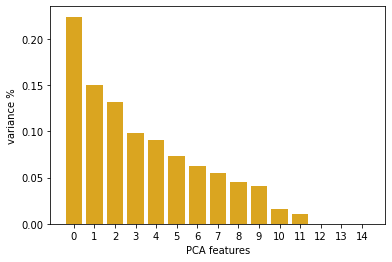

In [594]:
# Create a PCA instance: pca
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(X) # Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='goldenrod')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

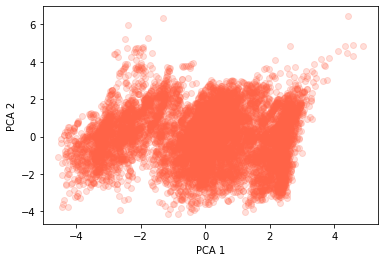

In [595]:
# Show the transformation
plt.scatter(PCA_components[0], PCA_components[1], alpha=0.2, color='tomato')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

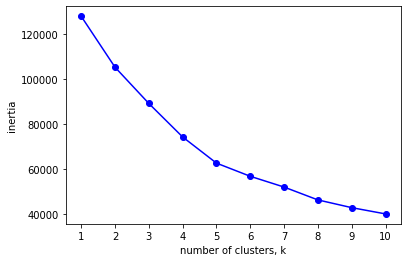

In [596]:
# use 10 PCA to build the Kmeans
ks = range(1, 11)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:10])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='blue')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [597]:
# Check the PCA Result
PCA_components.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-3.014294,0.247630,-0.679963,-0.684526,0.737702,-1.322253,0.687272,1.022983,-0.068142,0.754092,0.173640,0.330078,0.008915,-7.805975e-14,4.212220e-13
1,-2.859904,0.734432,-0.573277,-1.003121,0.600002,-1.675753,0.725728,0.852378,0.270377,-0.320285,0.021759,0.234900,0.008147,7.344281e-15,4.562735e-17
2,-2.895760,0.654897,-0.595077,-0.938961,0.628313,-1.531951,0.741040,0.757123,0.235132,-0.200406,-0.004773,0.180355,0.015879,2.607248e-13,1.148714e-14
3,-2.877791,0.676871,-0.589806,-0.946782,0.626391,-1.480283,0.758020,0.646811,0.270656,-0.304426,-0.057379,0.135042,0.018257,-1.439183e-13,-6.744537e-15
4,-3.118120,0.032958,-0.732680,-0.610665,0.769502,-0.993353,0.763200,0.642298,-0.020233,0.635820,0.173623,0.208735,0.011953,5.003617e-14,1.955839e-15


In [598]:
# use 10 PCA build 5 cluster Kmeans
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
pred_y = kmeans.fit_predict(PCA_components.iloc[:,:10])

sb_ds['clusters_pca'] = pred_y
collections.Counter(pred_y)

Counter({0: 1975, 1: 2160, 2: 2057, 3: 432, 4: 2136})

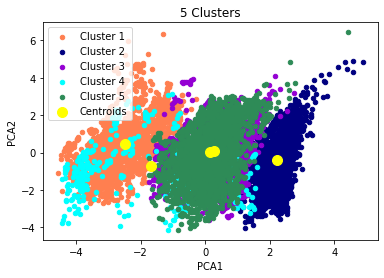

In [599]:
PCA1 = np.array(PCA_components.iloc[:,:10])
plt.scatter(PCA1[pred_y == 0, 0], PCA1[pred_y == 0, 1], s = 20, c = 'coral', label = 'Cluster 1')
plt.scatter(PCA1[pred_y == 1, 0], PCA1[pred_y == 1, 1], s = 20, c = 'navy', label = 'Cluster 2')
plt.scatter(PCA1[pred_y == 2, 0], PCA1[pred_y == 2, 1], s = 20, c = 'darkviolet', label = 'Cluster 3')
plt.scatter(PCA1[pred_y == 3, 0], PCA1[pred_y == 3, 1], s = 20, c = 'cyan', label = 'Cluster 4')
plt.scatter(PCA1[pred_y == 4, 0], PCA1[pred_y == 4, 1], s = 20, c = 'seagreen', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('5 Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [600]:
s = silhouette_score(PCA_components.iloc[:,:11], kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.3267123993357835


### **RCA**

In [601]:
# X[0]

In [602]:
# project to 2 Dimention
rca = GaussianRandomProjection(n_components=2, random_state=42)
X_rca=rca.fit_transform(X)
# K-Means Clustering Algorithm using RCA at 5 cluster
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
pred_y = kmeans.fit_predict(X_rca)
# print Silhouette Score
s_srp = silhouette_score(X, kmeans.labels_)
print('Silhouette Score:', s_srp)

Silhouette Score: 0.15145404592410827


In [603]:
# project to 12 Dimention
rca = GaussianRandomProjection(n_components=12, eps=0.1, random_state=42)
X_rca=rca.fit_transform(X)

# K-Means Clustering Algorithm using RCA at 5 cluster
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
pred_y = kmeans.fit_predict(X_rca)
sb_ds['clusters_RCA'] = pred_y # save to dataset

# print Silhouette Score (Best under 5 cluster)
s = silhouette_score(X, kmeans.labels_)
print('Silhouette Score:', s )

Silhouette Score: 0.20863237135522036


Text(0.5, 1.0, 'KMeans - RCA')

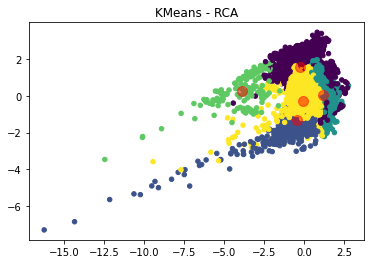

In [604]:
plt.scatter(X_rca[:, 0], X_rca[:, 1], c=pred_y, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)
plt.title('KMeans - RCA')

### **ICA**

In [605]:
#X[0]

In [606]:
# try use all components
ICA = FastICA(random_state = 42) 
X_ica=ICA.fit_transform(X)

# K-Means Clustering Algorithm using ICA 5 clusters at all components
kmeans = KMeans(n_clusters=5, init='k-means++', random_state = 42)
pred_y = kmeans.fit_predict(X_ica)

# print Silhouette Score
s = silhouette_score(X_ica, kmeans.labels_)
print('Silhouette Score:', s)

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Silhouette Score: 0.22759351849964005


In [607]:
# try use two components
ICA = FastICA(n_components=2, random_state = 42) 
X_ica=ICA.fit_transform(X)

# K-Means Clustering Algorithm using ICA 5 clusters at 2 components
kmeans = KMeans(n_clusters=5, init='k-means++', random_state = 42)
pred_y = kmeans.fit_predict(X_ica)
sb_ds['clusters_ica'] = pred_y

# print Silhouette Score (best)
s = silhouette_score(X_ica, kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.35905590525459835


Text(0.5, 1.0, 'KMeans - ICA')

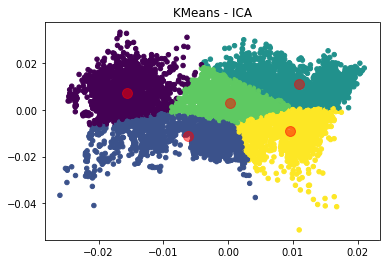

In [608]:
plt.scatter(X_ica[:, 0], X_ica[:, 1], c=pred_y, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)
plt.title('KMeans - ICA')

### **Feature Selection - Random Forest**

In [609]:
DB = pd.read_csv("/content/SeoulBikeData.csv",encoding='latin1')
# DB.head(3)
X = DB.iloc[:, 2:-1].values #drop date and Rent Bike Count, Hour
y = DB.iloc[:, -1].values
X[0], y

(array([0, -5.2, 37, 2.2, 2000, -17.6, 0.0, 0.0, 0.0, 'Winter',
        'No Holiday'], dtype=object),
 array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype=object))

In [610]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1,-2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)
X[0], y

(array([0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0, -5.2, 37, 2.2, 2000, -17.6, 0.0,
        0.0, 0.0], dtype=object), array([1, 1, 1, ..., 1, 1, 1]))

In [611]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(6132,) (6132, 15) (2628,) (2628, 15)


In [612]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [613]:
boolvec=sel.get_support()
boolvec.astype(bool)
print(boolvec)
DB.iloc[:, 3:-1].head(3)

[False False False False False False  True  True  True  True  True  True
  True False False]


,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday


In [614]:
print(DB.columns[2:9])

Index(['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)'],
      dtype='object')


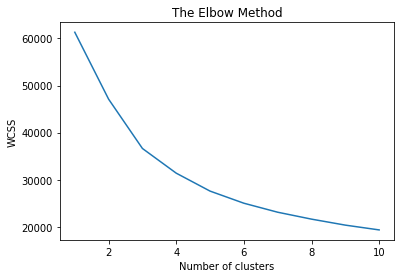

In [615]:
select_X = sc.fit_transform(DB.iloc[:, 2:9])

# Use Select featureto run Kmeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(select_X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [616]:
# choose 5 clusters
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(select_X)

In [617]:
s = silhouette_score(select_X, kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.24656885546261276


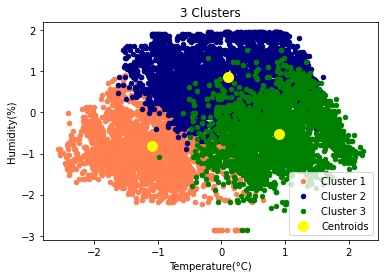

In [618]:
plt.scatter(select_X[y_kmeans == 0, 1], select_X[y_kmeans == 0, 2], s = 20, c = 'coral', label = 'Cluster 1')
plt.scatter(select_X[y_kmeans == 1, 1], select_X[y_kmeans == 1, 2], s = 20, c = 'navy', label = 'Cluster 2')
plt.scatter(select_X[y_kmeans == 2, 1], select_X[y_kmeans == 2, 2], s = 20, c = 'green', label = 'Cluster 3')
# plt.scatter(select_X[y_kmeans == 3, 0], select_X[y_kmeans == 3, 1], s = 20, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s = 100, c = 'yellow', label = 'Centroids')
plt.title('3 Clusters')
plt.xlabel('Temperature(°C)')
plt.ylabel('Humidity(%)')
plt.legend()
plt.show()

## **Expectation Maximization**

### **EM**

In [619]:
em_ds = pd.read_csv("/content/SeoulBikeData.csv",encoding='latin1') 
# em_ds.head(3) # view the data
X = em_ds.iloc[:, 2:-1].values #Drop date, Rented Bike Count, Houry
y = em_ds.iloc[:, -1].values
X[0],y

(array([0, -5.2, 37, 2.2, 2000, -17.6, 0.0, 0.0, 0.0, 'Winter',
        'No Holiday'], dtype=object),
 array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype=object))

In [620]:
# Encoding the X and Y
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1,-2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)
X = sc.fit_transform(X)
X[0],y, X.shape, y.shape

(array([-0.22775689,  0.22775689, -0.57629575, -0.58051386, -0.58051386,
         1.74801475, -1.66132477, -1.51395724, -1.04248288,  0.45847578,
         0.92587135, -1.65960467, -0.65513172, -0.13179988, -0.17189109]),
 array([1, 1, 1, ..., 1, 1, 1]),
 (8760, 15),
 (8760,))

In [621]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [622]:
# n_clusters=np.arange(2, 20)
# sils=[]
# sils_err=[]
# iterations=20
# for n in n_clusters:
#     tmp_sil=[]
#     for _ in range(iterations):
#         gmm = GaussianMixture(n, n_init=2).fit(X) 
#         labels=gmm.predict(X)
#         sil=silhouette_score(X, labels, metric='euclidean')
#         tmp_sil.append(sil)
#     val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
#     err=np.std(tmp_sil)
#     sils.append(val)
#     sils_err.append(err)

In [623]:
# plt.errorbar(n_clusters, sils, yerr=sils_err)
# plt.title("Silhouette Scores", fontsize=20)
# plt.xticks(n_clusters)
# plt.xlabel("N. of clusters")
# plt.ylabel("Score")

In [624]:
n_clusters=np.arange(2, 20)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X) 
        
        tmp_bic.append(gmm.bic(X))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

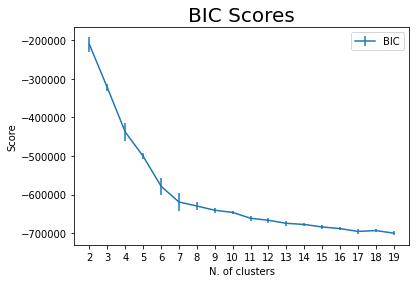

In [625]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

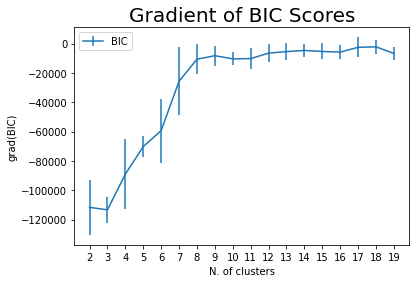

In [626]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

In [627]:
# fit model
model = GaussianMixture(n_components=8,covariance_type='tied',random_state=42)
model.fit(X)
# predict latent values
yhat = model.predict(X)

In [628]:
s = silhouette_score(X, yhat)
print('Silhouette Score:', s)

Silhouette Score: 0.2503140212447797


### **PCA - EM**

[2.24359890e-01 1.50120524e-01 1.31540224e-01 9.86412195e-02
 9.08556037e-02 7.32221314e-02 6.23061768e-02 5.54911354e-02
 4.54924837e-02 4.12993548e-02 1.59224608e-02 1.04481248e-02
 3.00670114e-04 6.56904630e-30 1.36130203e-30]


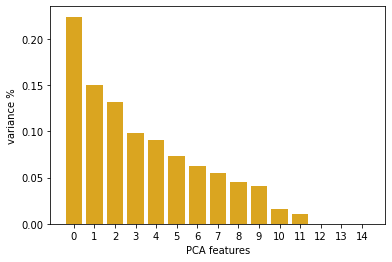

In [629]:
# Create a PCA instance: pca
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(X)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='goldenrod')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [630]:
PCA_components.iloc[:,:10].head(5)

,0,1,2,3,4,5,6,7,8,9
0,-3.014294,0.247630,-0.679963,-0.684526,0.737702,-1.322253,0.687272,1.022983,-0.068142,0.754092
1,-2.859904,0.734432,-0.573277,-1.003121,0.600002,-1.675753,0.725728,0.852378,0.270377,-0.320285
2,-2.895760,0.654897,-0.595077,-0.938961,0.628313,-1.531951,0.741040,0.757123,0.235132,-0.200406
3,-2.877791,0.676871,-0.589806,-0.946782,0.626391,-1.480283,0.758020,0.646811,0.270656,-0.304426
4,-3.118120,0.032958,-0.732680,-0.610665,0.769502,-0.993353,0.763200,0.642298,-0.020233,0.635820


In [631]:
# fit model
model = GaussianMixture(n_components=8,covariance_type='tied',random_state=42)
model.fit(PCA_components.iloc[:,:10])
# predict latent values
yhat_pca = model.predict(PCA_components.iloc[:,:10])
yhat_prob_pca=model.predict_proba(PCA_components.iloc[:,:10])

In [632]:
s = silhouette_score(PCA_components.iloc[:,:10], yhat_pca)
print('Silhouette Score:', s)

Silhouette Score: 0.2680693962255358


### **ICA - EM**

In [633]:
ICA = FastICA(n_components=2, random_state=42) 
X_ica=ICA.fit_transform(X)

In [634]:
model = GaussianMixture(n_components=8,covariance_type='tied',random_state=42)
model.fit(X_ica)
# predict latent values
yhat_ica = model.predict(X_ica)
yhat_prob_ica = model.predict(X_ica)

In [635]:
sil=silhouette_score(X_ica, yhat_ica, metric='euclidean')
print('Silhouette Score:', sil)

Silhouette Score: 0.33760583905263736


In [636]:
ICA = FastICA(n_components=4, random_state=42) 
X_ica=ICA.fit_transform(X)

In [637]:
model = GaussianMixture(n_components=8,covariance_type='tied',random_state=42)
model.fit(X_ica)
# predict latent values
yhat_ica = model.predict(X_ica)
yhat_prob_ica = model.predict(X_ica)

In [638]:
sil=silhouette_score(X_ica, yhat_ica, metric='euclidean')
print('Silhouette Score:', sil)

Silhouette Score: 0.3515679966165885


Text(0.5, 0, 'Temperature(°C)')

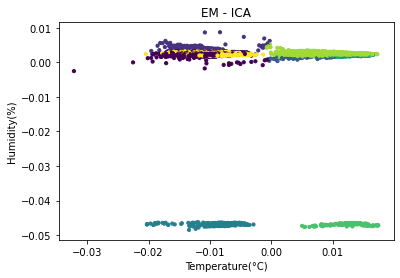

In [639]:
plt.scatter(X_ica[:, 0], X_ica[:, 1], c=yhat_ica, s=10, cmap='viridis')
plt.title('EM - ICA')
plt.ylabel('Humidity(%)')
plt.xlabel('Temperature(°C)')

###**RCA**

In [640]:
# project 2 Dim
rca = GaussianRandomProjection(n_components=2, eps=0.1, random_state=42)
X_rca=rca.fit_transform(X)

# 5 clusters
model = GaussianMixture(n_components=8,covariance_type='tied',random_state=42)
model.fit(X_rca)

# predict latent values
yhat_rca = model.predict(X_rca)
yhat_prob_rca = model.predict(X_rca)

# Silhouette Score
s=silhouette_score(X_rca, yhat_rca, metric='euclidean')
print('Silhouette Score:', s)

Silhouette Score: 0.26833040336106634


In [641]:
# project 5 Dim
rca = GaussianRandomProjection(n_components=5, eps=0.1, random_state=42)
X_rca=rca.fit_transform(X)

# 5 clusters
model = GaussianMixture(n_components=8,covariance_type='tied',random_state=42)
model.fit(X_rca)

# predict latent values
yhat_rca = model.predict(X_rca)
yhat_prob_rca = model.predict(X_rca)

# Silhouette Score
s=silhouette_score(X_rca, yhat_rca, metric='euclidean')
print('Silhouette Score:', s)


Silhouette Score: 0.31144146908567155


Text(0.5, 0, 'Temperature(°C)')

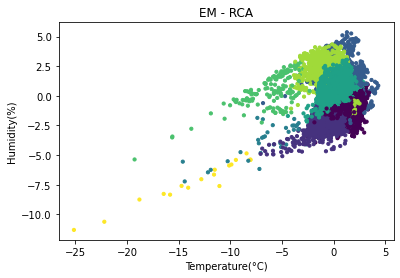

In [642]:
# plot
plt.scatter(X_rca[:, 0], X_rca[:, 1], c=yhat_rca, s=10, cmap='viridis')
plt.title('EM - RCA')
plt.ylabel('Humidity(%)')
plt.xlabel('Temperature(°C)')

### **Random Forest - EM**

In [643]:
DB = pd.read_csv("/content/SeoulBikeData.csv",encoding='latin1')
X = DB.iloc[:, 2:-1].values #drop date and Rent Bike Count, Hour
y = DB.iloc[:, -1].values

In [644]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1,-2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)

In [645]:
X[0], y

(array([0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0, -5.2, 37, 2.2, 2000, -17.6, 0.0,
        0.0, 0.0], dtype=object), array([1, 1, 1, ..., 1, 1, 1]))

In [646]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(6132,) (6132, 15) (2628,) (2628, 15)


In [647]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [648]:
boolvec=sel.get_support()
boolvec.astype(bool)
boolvec

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True, False, False])

In [649]:
selected_feat = DB.columns[2:9]
print(selected_feat)

Index(['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)'],
      dtype='object')


In [650]:
select_X = sc.fit_transform(DB.iloc[:, 2:9])

# fit model
model = GaussianMixture(n_components=8,covariance_type='tied',random_state=42)
model.fit(select_X)
# predict latent values
yhat_rf = model.predict(select_X)
yhat_prob_rf = model.predict(select_X)

In [651]:
#labels=gmm.predict(X)
sil=silhouette_score(select_X, yhat_rf, metric='euclidean')
print('Silhouette Score:', sil)

Silhouette Score: 0.14087999224623224


Text(0.5, 0, 'Temperature(°C)')

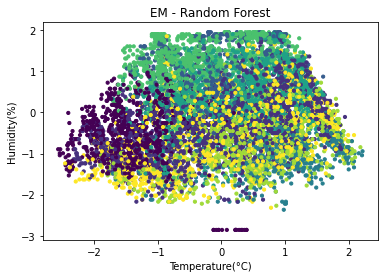

In [652]:
# plot
plt.scatter(select_X[:, 1], select_X[:, 2], c=yhat_rf, s=10, cmap='viridis')
plt.title('EM - Random Forest')
plt.ylabel('Humidity(%)')
plt.xlabel('Temperature(°C)')

### **Neural Network on Cluster Output**

In [653]:
X=np.array(yhat_prob_pca)
y=np.array(yhat_pca)

In [654]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(6132, 8)


In [655]:
# define the model
#get number of columns in training data
n_cols=X_train.shape[1]

# define model 2 layers
model = Sequential()
model.add(Dense(8, input_dim=n_cols, activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(8, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [656]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
50/50 [==============================] - 1s 12ms/step - loss: 0.6591 - accuracy: 0.0332 - val_loss: 0.6254 - val_accuracy: 0.2168
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.5909 - accuracy: 0.2316 - val_loss: 0.5559 - val_accuracy: 0.2168
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.5197 - accuracy: 0.2316 - val_loss: 0.4839 - val_accuracy: 0.2168
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.4466 - accuracy: 0.2316 - val_loss: 0.4127 - val_accuracy: 0.2168
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.3847 - accuracy: 0.3176 - val_loss: 0.3626 - val_accuracy: 0.3936
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 0.3397 - accuracy: 0.4133 - val_loss: 0.3219 - val_accuracy: 0.3977
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 0.3003 - accuracy: 0.5105 - val_loss: 0.2853 - val_accuracy: 0.5786
Epoch 8/100


In [657]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=1)

83/83 [==============================] - 0s 989us/step


In [658]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print('precision: %f' % precision)
#print('Precision: %f' % precision)
# recall: tp / (tp + fn)
#recall = recall_score(y_test, yhat_classes)
#print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_test, yhat_classes)
#print('F1 score: %f' % f1)

Accuracy: 0.998478
precision: 0.998485


In [659]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)

ROC AUC: 1.000000


In [660]:
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[150   0   0   0   0   0   0   1]
 [  0 171   0   0   2   0   0   0]
 [  0   0 133   0   0   0   0   0]
 [  0   0   0 566   0   0   0   0]
 [  0   0   0   0 471   0   0   0]
 [  0   0   0   0   0 127   0   0]
 [  0   0   1   0   0   0 496   0]
 [  0   0   0   0   0   0   0 510]]


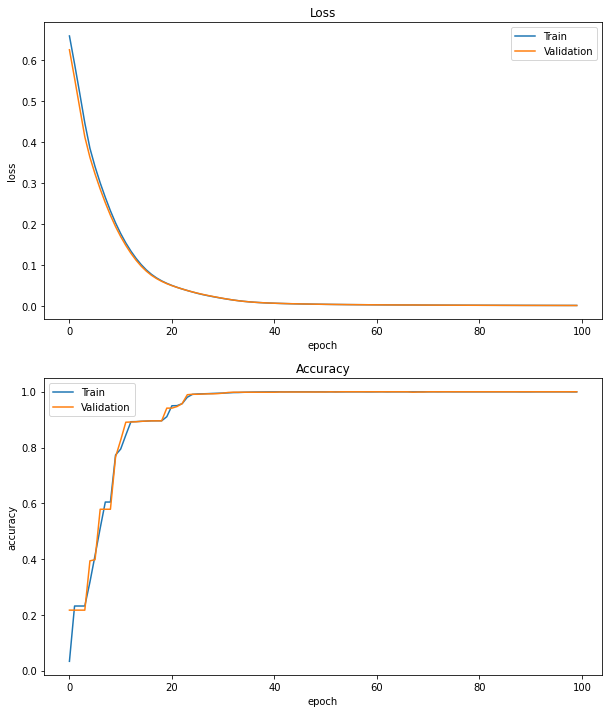

In [661]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

##**Ann-dimension-reduction**

### **PCA**

In [662]:
data = pd.read_csv("/content/SeoulBikeData.csv",encoding='latin1') 
X = data.iloc[:, 2:-1].values
y = data.iloc[:, -1].values
X[0],y

(array([0, -5.2, 37, 2.2, 2000, -17.6, 0.0, 0.0, 0.0, 'Winter',
        'No Holiday'], dtype=object),
 array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype=object))

In [663]:
# Encoding the X and Y
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1,-2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)
X = sc.fit_transform(X)
X[0],y, X.shape, y.shape

(array([-0.22775689,  0.22775689, -0.57629575, -0.58051386, -0.58051386,
         1.74801475, -1.66132477, -1.51395724, -1.04248288,  0.45847578,
         0.92587135, -1.65960467, -0.65513172, -0.13179988, -0.17189109]),
 array([1, 1, 1, ..., 1, 1, 1]),
 (8760, 15),
 (8760,))

[2.24359890e-01 1.50120524e-01 1.31540224e-01 9.86412195e-02
 9.08556037e-02 7.32221314e-02 6.23061768e-02 5.54911354e-02
 4.54924837e-02 4.12993548e-02 1.59224608e-02 1.04481248e-02
 3.00670114e-04 6.56904630e-30 1.36130203e-30]


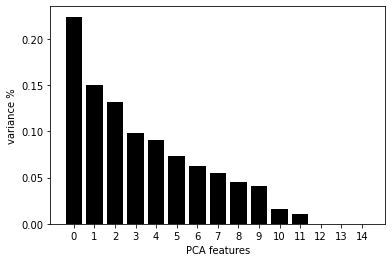

In [664]:
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(X)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [665]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(PCA_components.iloc[:,:10], y, test_size=0.3, random_state=42)

In [666]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(6132, 2)


In [667]:
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 4 layers
model = Sequential()
model.add(Dense(10, input_dim=n_cols, activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [668]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
50/50 [==============================] - 0s 5ms/step - loss: 0.5871 - accuracy: 0.9676 - val_loss: 0.5072 - val_accuracy: 0.9584
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.3942 - accuracy: 0.9676 - val_loss: 0.2987 - val_accuracy: 0.9584
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2203 - accuracy: 0.9676 - val_loss: 0.1948 - val_accuracy: 0.9584
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1545 - accuracy: 0.9676 - val_loss: 0.1663 - val_accuracy: 0.9584
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.9676 - val_loss: 0.1563 - val_accuracy: 0.9584
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.9676 - val_loss: 0.1502 - val_accuracy: 0.9584
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1216 - accuracy: 0.9676 - val_loss: 0.1456 - val_accuracy: 0.9584
Epoch 8/100
5

In [669]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

83/83 [==============================] - 0s 794us/step


In [670]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.968417
Precision: 0.968750
Recall: 0.999607
F1 score: 0.983937


In [671]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.930350
[[   3   82]
 [   1 2542]]


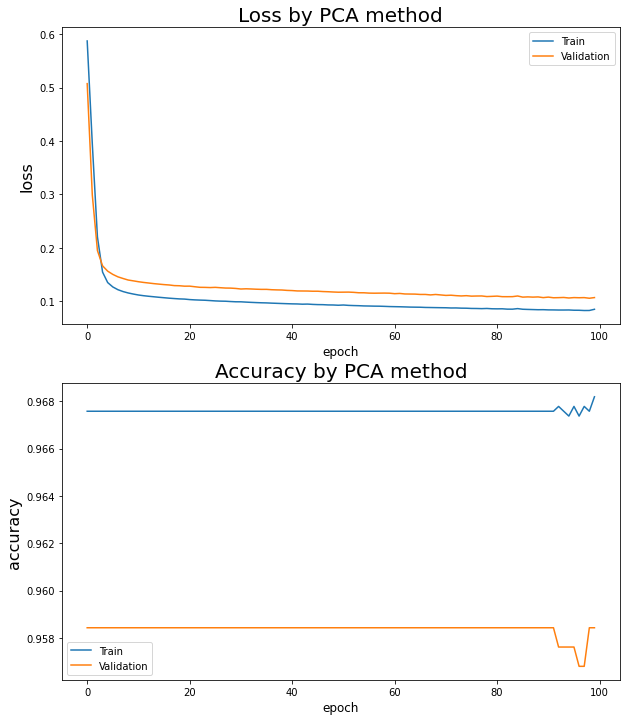

In [672]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss by PCA method', fontsize=20)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy by PCA method', fontsize=20)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.legend()
plt.show()

###**RCA**

In [673]:
data = pd.read_csv("/content/SeoulBikeData.csv",encoding='latin1') 
X = data.iloc[:, 2:-1].values
y = data.iloc[:, -1].values
X[0],y

(array([0, -5.2, 37, 2.2, 2000, -17.6, 0.0, 0.0, 0.0, 'Winter',
        'No Holiday'], dtype=object),
 array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype=object))

In [674]:
# Encoding the X and Y
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1,-2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)
X = sc.fit_transform(X)
X[0],y, X.shape, y.shape

(array([-0.22775689,  0.22775689, -0.57629575, -0.58051386, -0.58051386,
         1.74801475, -1.66132477, -1.51395724, -1.04248288,  0.45847578,
         0.92587135, -1.65960467, -0.65513172, -0.13179988, -0.17189109]),
 array([1, 1, 1, ..., 1, 1, 1]),
 (8760, 15),
 (8760,))

In [675]:
rca = GaussianRandomProjection(n_components=5, eps=0.1, random_state=42)
X_rca = rca.fit_transform(X)

In [676]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_rca, y, test_size=0.3, random_state=42)

In [677]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(6132, 2)


In [678]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(5, input_dim=n_cols, activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [679]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
50/50 [==============================] - 0s 4ms/step - loss: 0.3834 - accuracy: 0.9676 - val_loss: 0.3079 - val_accuracy: 0.9584
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2408 - accuracy: 0.9676 - val_loss: 0.2020 - val_accuracy: 0.9584
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1613 - accuracy: 0.9676 - val_loss: 0.1623 - val_accuracy: 0.9584
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1357 - accuracy: 0.9676 - val_loss: 0.1533 - val_accuracy: 0.9584
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9676 - val_loss: 0.1511 - val_accuracy: 0.9584
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1250 - accuracy: 0.9676 - val_loss: 0.1503 - val_accuracy: 0.9584
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1238 - accuracy: 0.9676 - val_loss: 0.1498 - val_accuracy: 0.9584
Epoch 8/100
5

In [680]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

83/83 [==============================] - 0s 853us/step


In [681]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.967656
Precision: 0.967656
Recall: 1.000000
F1 score: 0.983562


In [682]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.860795
[[   0   85]
 [   0 2543]]


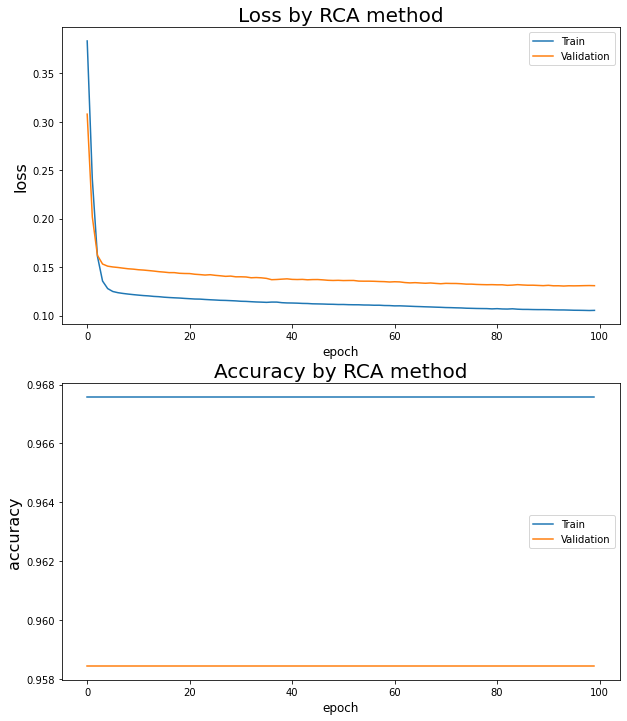

In [683]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss by RCA method', fontsize= 20)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss', fontsize= 16)
plt.xlabel('epoch', fontsize= 12)
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy by RCA method', fontsize= 20)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy', fontsize= 16)
plt.xlabel('epoch', fontsize= 12)
plt.legend()
plt.show()

###**Feature Selection - Random Forest**

In [684]:
DB = pd.read_csv("/content/SeoulBikeData.csv",encoding='latin1')
# DB.head(3)
X = DB.iloc[:, 2:-1].values #drop date and Rent Bike Count, Hour
y = DB.iloc[:, -1].values
X[0], y

(array([0, -5.2, 37, 2.2, 2000, -17.6, 0.0, 0.0, 0.0, 'Winter',
        'No Holiday'], dtype=object),
 array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype=object))

In [685]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1,-2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)
X[0], y

(array([0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0, -5.2, 37, 2.2, 2000, -17.6, 0.0,
        0.0, 0.0], dtype=object), array([1, 1, 1, ..., 1, 1, 1]))

In [686]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(6132,) (6132, 15) (2628,) (2628, 15)


In [687]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [688]:
boolvec=sel.get_support()
boolvec.astype(bool)
print(boolvec)
DB.iloc[:, 2:-1].head(3)

[False False False False False False  True  True  True  True  True  True
  True False False]


,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
1,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
2,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday


In [689]:
print(DB.columns[2:9])

Index(['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)'],
      dtype='object')


In [690]:
X_RF= sc.fit_transform(DB.iloc[:, 2:9])
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_RF, y, test_size=0.3, random_state=42)

In [691]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(6132, 2)


In [692]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 4 layers
model = Sequential()
model.add(Dense(7, input_dim=n_cols, activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [693]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
50/50 [==============================] - 0s 4ms/step - loss: 0.5332 - accuracy: 0.9655 - val_loss: 0.4685 - val_accuracy: 0.9584
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.3849 - accuracy: 0.9676 - val_loss: 0.3230 - val_accuracy: 0.9584
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2542 - accuracy: 0.9676 - val_loss: 0.2265 - val_accuracy: 0.9584
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1834 - accuracy: 0.9676 - val_loss: 0.1868 - val_accuracy: 0.9584
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 0.9676 - val_loss: 0.1753 - val_accuracy: 0.9584
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9676 - val_loss: 0.1710 - val_accuracy: 0.9584
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9676 - val_loss: 0.1682 - val_accuracy: 0.9584
Epoch 8/100
5

In [694]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

83/83 [==============================] - 0s 874us/step


In [695]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.967656
Precision: 0.967656
Recall: 1.000000
F1 score: 0.983562


In [696]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.854280
[[   0   85]
 [   0 2543]]


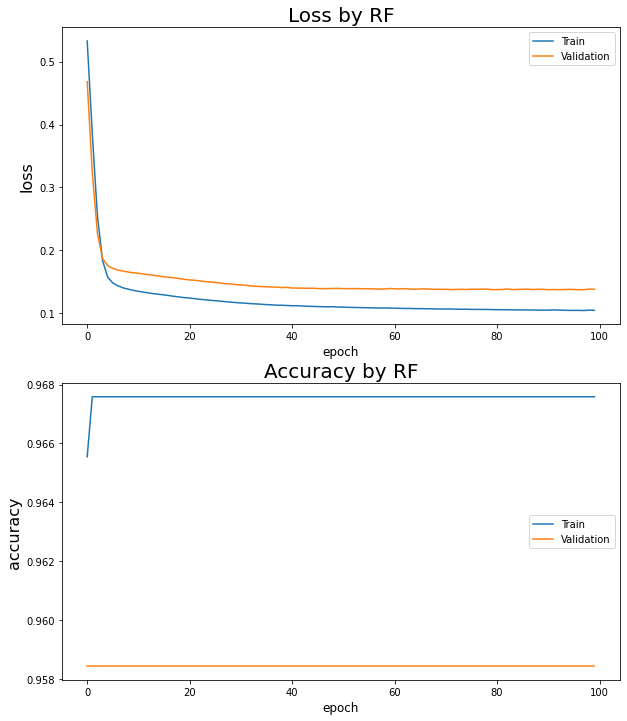

In [697]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss by RF', fontsize= 20)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy by RF',fontsize=20)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy',fontsize=16)
plt.xlabel('epoch',fontsize=12)
plt.legend()
plt.show()

###**ICA**

In [698]:
data = pd.read_csv("/content/SeoulBikeData.csv",encoding='latin1') 
X = data.iloc[:, 2:-1].values
y = data.iloc[:, -1].values
X[0],y

(array([0, -5.2, 37, 2.2, 2000, -17.6, 0.0, 0.0, 0.0, 'Winter',
        'No Holiday'], dtype=object),
 array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype=object))

In [699]:
# Encoding the X and Y
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1,-2])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)
X = sc.fit_transform(X)
X[0],y, X.shape, y.shape

(array([-0.22775689,  0.22775689, -0.57629575, -0.58051386, -0.58051386,
         1.74801475, -1.66132477, -1.51395724, -1.04248288,  0.45847578,
         0.92587135, -1.65960467, -0.65513172, -0.13179988, -0.17189109]),
 array([1, 1, 1, ..., 1, 1, 1]),
 (8760, 15),
 (8760,))

In [700]:
ICA = FastICA(n_components=4, random_state=42) 
X_ica=ICA.fit_transform(X)

In [701]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_ica, y, test_size=0.3, random_state=42)

In [702]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(6132, 2)


In [703]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(4, input_dim=n_cols, activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [704]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6601 - accuracy: 0.9496 - val_loss: 0.6155 - val_accuracy: 0.9584
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.5511 - accuracy: 0.9676 - val_loss: 0.4792 - val_accuracy: 0.9584
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.3959 - accuracy: 0.9676 - val_loss: 0.3225 - val_accuracy: 0.9584
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2509 - accuracy: 0.9676 - val_loss: 0.2205 - val_accuracy: 0.9584
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1769 - accuracy: 0.9676 - val_loss: 0.1850 - val_accuracy: 0.9584
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1530 - accuracy: 0.9676 - val_loss: 0.1764 - val_accuracy: 0.9584
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.9676 - val_loss: 0.1742 - val_accuracy: 0.9584
Epoch 8/100
5

In [705]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

83/83 [==============================] - 0s 779us/step


In [706]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.967656
Precision: 0.967656
Recall: 1.000000
F1 score: 0.983562


In [707]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.700436
[[   0   85]
 [   0 2543]]


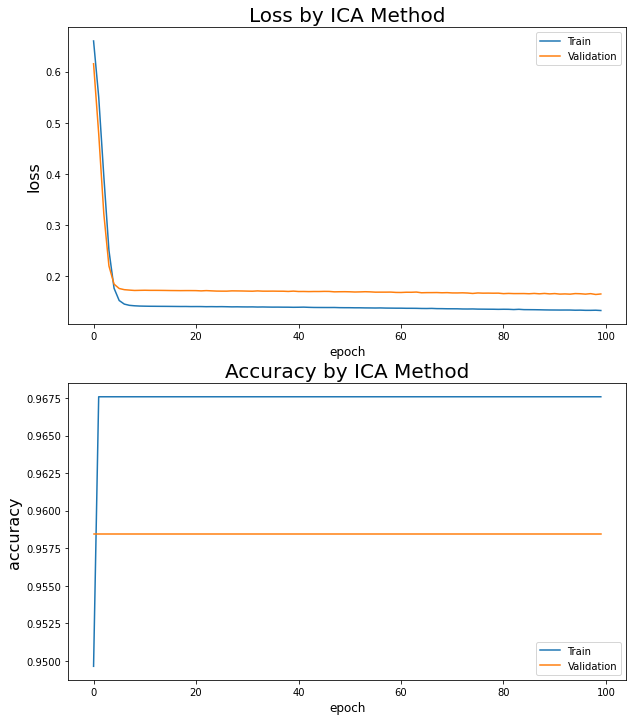

In [708]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss by ICA Method',fontsize=20)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss',fontsize=16)
plt.xlabel('epoch',fontsize=12)
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy by ICA Method', fontsize=20)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy',fontsize=16)
plt.xlabel('epoch',fontsize=12)
plt.legend()
plt.show()

# **IBM HR**

## **Data Processing**

In [709]:
ibm_ds = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
ibm_ds = ibm_ds.drop(['PercentSalaryHike','EmployeeCount','EmployeeNumber'], axis=1) #Drop PercentSalaryHike
PerformanceRating = ibm_ds['PerformanceRating']
ibm_ds.drop(labels=['PerformanceRating'], axis=1, inplace = True)
ibm_ds.insert(0, 'PerformanceRating', PerformanceRating)
ibm_ds.head(3)# view the data

,PerformanceRating,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,3,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,1,80,0,8,0,1,6,4,0,5
1,4,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,4,80,1,10,3,3,10,7,1,7
2,3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,2,80,0,7,3,3,0,0,0,0


In [710]:
X = ibm_ds.iloc[:, 1:].values 
y = ibm_ds.iloc[:,0].values # PerformanceRating 0=>3, 1=>4
X[0],y

(array([41, 'Yes', 'Travel_Rarely', 1102, 'Sales', 1, 2, 'Life Sciences',
        2, 'Female', 94, 3, 2, 'Sales Executive', 4, 'Single', 5993, 19479,
        8, 'Y', 'Yes', 1, 80, 0, 8, 0, 1, 6, 4, 0, 5], dtype=object),
 array([3, 4, 3, ..., 4, 3, 3]))

In [711]:
# Encoding the X and Y
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,4,7,9,13,15,19,20])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
le = LabelEncoder()
y = le.fit_transform(y)

In [712]:
#X[0]

In [713]:
sc = StandardScaler()
X = sc.fit_transform(X)
X[0],y, X.shape, y.shape

(array([-2.28090588,  2.28090588, -0.33709993, -0.48185865,  0.63984058,
        -0.21160368, -1.37405084,  1.51524392, -0.13678823,  1.19404463,
        -0.34825488, -0.67914108, -0.24305927, -0.31409347,  1.22474487,
        -1.22474487, -0.3127846 , -0.1914977 , -0.46246387, -0.27305934,
        -0.33080804, -0.23990406, -0.49787324,  1.87328654, -0.24462499,
        -0.53487311, -0.91892141,  1.45864991,  0.        , -1.59174553,
         1.59174553,  0.4463504 ,  0.74252653, -1.01090934, -0.89168825,
        -0.66053067,  1.38313827,  0.37967213, -0.05778755,  1.15325359,
        -0.10834951,  0.72601994,  2.12513592, -1.58417824,  0.        ,
        -0.93201439, -0.42164246, -2.17198183, -2.49382042, -0.16461311,
        -0.0632959 , -0.67914568,  0.24583399]),
 array([0, 1, 0, ..., 1, 0, 0]),
 (1470, 53),
 (1470,))

## **K-Means**

###**K-means**

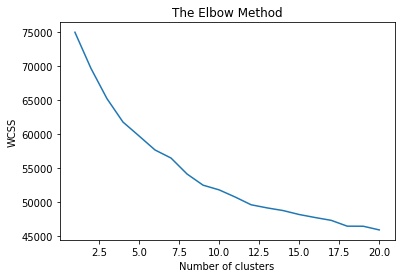

In [714]:
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 21), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [715]:
kmeans = KMeans(n_clusters = 9, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
ibm_ds['clusters1'] = y_kmeans # add cluster to the original dateset
collections.Counter(y_kmeans)

Counter({0: 131, 1: 52, 2: 292, 3: 80, 4: 325, 5: 103, 6: 259, 7: 83, 8: 145})

In [716]:
# before selection Kmeans Silhouette Score
s = silhouette_score(X, kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.11931958485986921


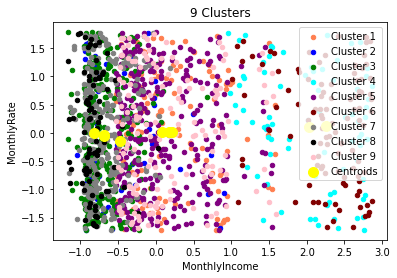

In [717]:
# Use MonthlyIncome and MonthlyRate show 9 cluster 
plt.scatter(X[y_kmeans == 0, -13], X[y_kmeans == 0, -12], s = 20, c = 'coral', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, -13], X[y_kmeans == 1, -12], s = 20, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, -13], X[y_kmeans == 2, -12], s = 20, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, -13], X[y_kmeans == 3, -12], s = 20, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, -13], X[y_kmeans == 4, -12], s = 20, c = 'purple', label = 'Cluster 5')
plt.scatter(X[y_kmeans == 5, -13], X[y_kmeans == 5, -12], s = 20, c = 'maroon', label = 'Cluster 6')
plt.scatter(X[y_kmeans == 6, -13], X[y_kmeans == 6, -12], s = 20, c = 'gray', label = 'Cluster 7')
plt.scatter(X[y_kmeans == 7, -13], X[y_kmeans == 7, -12], s = 20, c = 'black', label = 'Cluster 8')
plt.scatter(X[y_kmeans == 8, -13], X[y_kmeans == 8, -12], s = 20, c = 'pink', label = 'Cluster 9')
plt.scatter(kmeans.cluster_centers_[:, -13], kmeans.cluster_centers_[:, -12], s = 100, c = 'yellow', label = 'Centroids')
plt.title('9 Clusters')
plt.xlabel('MonthlyIncome')
plt.ylabel('MonthlyRate')
plt.legend()
plt.show()

### **PCA**

In [718]:
#X[0]

[1.07415431e-01 7.00874168e-02 5.18129226e-02 4.98581796e-02
 4.13555747e-02 4.04179809e-02 3.83274223e-02 3.55636542e-02
 3.18191931e-02 3.15814567e-02 2.90134821e-02 2.59800842e-02
 2.48637123e-02 2.39036331e-02 2.30529699e-02 2.24669135e-02
 2.23463175e-02 2.19284325e-02 2.12577688e-02 2.04421280e-02
 1.99581687e-02 1.96833623e-02 1.91720793e-02 1.88714335e-02
 1.84668805e-02 1.82309071e-02 1.81108697e-02 1.74952015e-02
 1.70972634e-02 1.57343980e-02 1.48500953e-02 1.34285744e-02
 1.09537452e-02 9.83169854e-03 9.40795306e-03 6.99313947e-03
 5.44669638e-03 4.40524828e-03 2.90969653e-03 2.18452827e-03
 1.58102524e-03 1.01268826e-03 6.79672888e-04 2.25120504e-31
 2.50620343e-32 2.31358468e-32 1.32141187e-32 9.98453052e-33
 2.42659242e-33 1.81052842e-33 1.06289842e-33 5.78872117e-34
 6.94318503e-35]


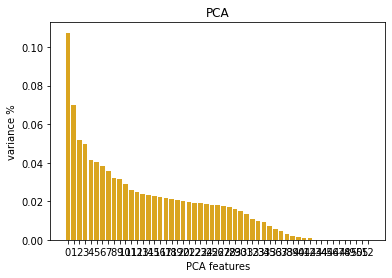

In [719]:
# Create a PCA instance: pca
pca = PCA(n_components=53)
principalComponents = pca.fit_transform(X) # Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='goldenrod')
plt.title('PCA')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

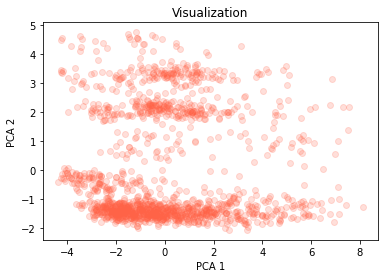

In [720]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=0.2, color='tomato')
plt.title('Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

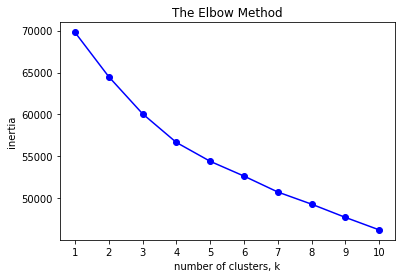

In [721]:
ks = range(1, 11)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:31])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='blue')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title('The Elbow Method')
plt.xticks(ks)
plt.show()

In [722]:
# PCA_components.iloc[:,:10]

In [723]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(PCA_components.iloc[:,:31])

ibm_ds['clusters_pca'] = pred_y
collections.Counter(pred_y)

Counter({0: 246, 1: 202, 2: 687, 3: 335})

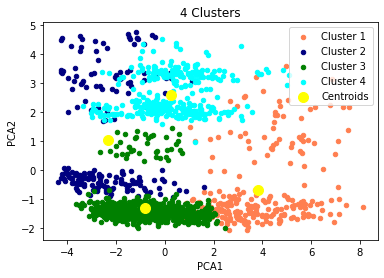

In [724]:
PCA1 = np.array(PCA_components.iloc[:,:31])
plt.scatter(PCA1[pred_y == 0, 0], PCA1[pred_y == 0, 1], s = 20, c = 'coral', label = 'Cluster 1')
plt.scatter(PCA1[pred_y == 1, 0], PCA1[pred_y == 1, 1], s = 20, c = 'navy', label = 'Cluster 2')
plt.scatter(PCA1[pred_y == 2, 0], PCA1[pred_y == 2, 1], s = 20, c = 'green', label = 'Cluster 3')
plt.scatter(PCA1[pred_y == 3, 0], PCA1[pred_y == 3, 1], s = 20, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('4 Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [725]:
s = silhouette_score(PCA_components.iloc[:,:31], kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.08496781699476094


### **RCA**

In [726]:
#X[0]

In [727]:
maxlist=[]
for i in range(1,53):
  rca = GaussianRandomProjection(n_components=i, eps=0.1, random_state=42)
  X_rca=rca.fit_transform(X)

  ## K-Means Clustering Algorithm using RCA
  kmeans = KMeans(n_clusters=9, init='k-means++', random_state=0)
  pred_y = kmeans.fit_predict(X_rca)
  s_srp = silhouette_score(X, kmeans.labels_)
  maxlist.append(s_srp)
  print('rca:{}, Silhouette Score:{}'.format(i,s_srp))

print(max(maxlist)) 

rca:1, Silhouette Score:-0.025032667499377145
rca:2, Silhouette Score:-0.01059909635376629
rca:3, Silhouette Score:-0.0023220480828422506
rca:4, Silhouette Score:0.00012613715812401322
rca:5, Silhouette Score:0.013250175262195433
rca:6, Silhouette Score:0.01744747128329931
rca:7, Silhouette Score:0.02025794128987803
rca:8, Silhouette Score:0.015772099502618993
rca:9, Silhouette Score:0.021745958204056563
rca:10, Silhouette Score:0.029063189565382026
rca:11, Silhouette Score:0.02951375300065447
rca:12, Silhouette Score:0.02905475196771267
rca:13, Silhouette Score:0.03710097837443263
rca:14, Silhouette Score:0.043346214432027824
rca:15, Silhouette Score:0.04991520402867735
rca:16, Silhouette Score:0.04552925749866712
rca:17, Silhouette Score:0.05815420154984095
rca:18, Silhouette Score:0.05043015543997281
rca:19, Silhouette Score:0.05391172384999134
rca:20, Silhouette Score:0.0721187871813573
rca:21, Silhouette Score:0.07149052163244199
rca:22, Silhouette Score:0.06168438880714657
rca:23

In [728]:
rca = GaussianRandomProjection(n_components=42, eps=0.1, random_state=42)
X_rca=rca.fit_transform(X)

In [729]:
## K-Means Clustering Algorithm using RCA
kmeans = KMeans(n_clusters=9, init='k-means++', random_state=0)
pred_y = kmeans.fit_predict(X_rca)

ibm_ds['clusters_RCA'] = pred_y      

In [730]:
s_srp = silhouette_score(X, kmeans.labels_)
print('Silhouette Score:', s_srp)

Silhouette Score: 0.0936511916487565


Text(0, 0.5, 'RCA 2')

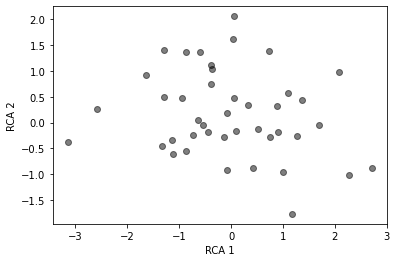

In [731]:
plt.scatter(X_rca[0], X_rca[1], alpha=.5, color='black')
plt.xlabel('RCA 1')
plt.ylabel('RCA 2')

Text(0, 0.5, 'RCA 2')

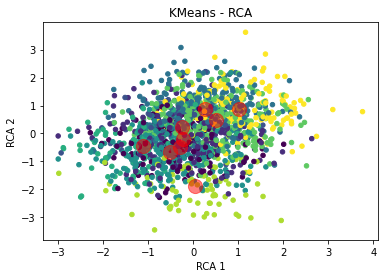

In [732]:
#print(correct/len(X_ica))
#yp=kmeans.predict(ica_X_train)
plt.scatter(X_rca[:, 0], X_rca[:, 1], c=pred_y, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('KMeans - RCA')
plt.xlabel('RCA 1')
plt.ylabel('RCA 2')

In [733]:
collections.Counter(kmeans.labels_)

Counter({0: 135, 1: 194, 2: 55, 3: 231, 4: 278, 5: 94, 6: 260, 7: 80, 8: 143})

### **ICA**

In [734]:
# X[0]

In [735]:
maxlist=[]
for i in range(1,53):

  ICA = FastICA(n_components=i, random_state=42) 
  X_ica=ICA.fit_transform(X)
  kmeans = KMeans(n_clusters=9, init='k-means++', random_state=42)
  pred_y = kmeans.fit_predict(X_ica)
  s = silhouette_score(X_ica, kmeans.labels_)
  maxlist.append(s)
  print('ica:{}, Silhouette Score:{}'.format(i,s))      

maxlist.sort(reverse=True)
print(maxlist[1]) 

ica:1, Silhouette Score:0.5317122644054822
ica:2, Silhouette Score:0.42908987095693624
ica:3, Silhouette Score:0.3625248684964627
ica:4, Silhouette Score:0.33633375863993087
ica:5, Silhouette Score:0.28746665223808654
ica:6, Silhouette Score:0.23829770468860864
ica:7, Silhouette Score:0.23432859979676635
ica:8, Silhouette Score:0.16902625243691086
ica:9, Silhouette Score:0.14060896435581796
ica:10, Silhouette Score:0.11332995659764551
ica:11, Silhouette Score:0.1418661398689336
ica:12, Silhouette Score:0.1101963772337042


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:13, Silhouette Score:0.10708406634710262
ica:14, Silhouette Score:0.11337392536353715
ica:15, Silhouette Score:0.09709916066093208
ica:16, Silhouette Score:0.13124700548217982
ica:17, Silhouette Score:0.1305575691906442


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:18, Silhouette Score:0.15812574602686494


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:19, Silhouette Score:0.1577796227816406


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:20, Silhouette Score:0.1344713764970982
ica:21, Silhouette Score:0.13411719565539582
ica:22, Silhouette Score:0.12416176832020148


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:23, Silhouette Score:0.10830772576568089
ica:24, Silhouette Score:0.1115543233370209


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:25, Silhouette Score:0.11801396052982399


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:26, Silhouette Score:0.12743728496426174


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:27, Silhouette Score:0.10639230565245128


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:28, Silhouette Score:0.10960076985403074


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:29, Silhouette Score:0.09331777433526486


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:30, Silhouette Score:0.11685492723763383


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:31, Silhouette Score:0.09994709315850514
ica:32, Silhouette Score:0.09905816081116771
ica:33, Silhouette Score:0.10712064755156164
ica:34, Silhouette Score:0.08523070306855962
ica:35, Silhouette Score:0.09434911131332509
ica:36, Silhouette Score:0.09330344129961897


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:37, Silhouette Score:0.08620241259751327


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:38, Silhouette Score:0.08679990392670003


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:39, Silhouette Score:0.065129882840415


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:40, Silhouette Score:0.07695280669192738


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:41, Silhouette Score:0.06379916560229426


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:42, Silhouette Score:0.05050715469078236
ica:43, Silhouette Score:0.060606772037237466


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:44, Silhouette Score:0.04332195233673858


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:45, Silhouette Score:0.057699127612892795


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:46, Silhouette Score:0.05716391289827311


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:47, Silhouette Score:0.05537029912219262


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:48, Silhouette Score:0.07069247069863838


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:49, Silhouette Score:0.055159497888302


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:50, Silhouette Score:0.05963212856379014


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:51, Silhouette Score:0.0695265017288299


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:52, Silhouette Score:0.06637141279485244
0.42908987095693624


In [736]:
ICA = FastICA(n_components=2, random_state=42) 
X_ica=ICA.fit_transform(X)

In [737]:
## K-Means Clustering Algorithm using ICA
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_ica)

ibm_ds['clusters_ica'] = pred_y      

In [738]:
s = silhouette_score(X_ica, kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.42663196162424694


Text(0, 0.5, 'ICA 2')

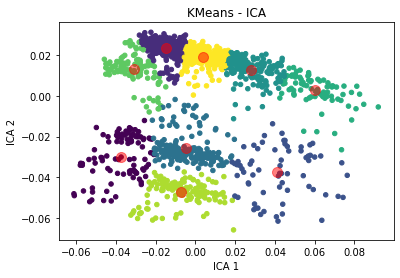

In [739]:
#print(correct/len(X_ica))
#yp=kmeans.predict(ica_X_train)
plt.scatter(X_ica[:, 0], X_ica[:, 1], c=pred_y, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)
plt.title('KMeans - ICA')
plt.xlabel('ICA 1')
plt.ylabel('ICA 2')

### **Feature Selection - Random Forest**

In [740]:
DB = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
DB = DB.drop(['PercentSalaryHike','EmployeeCount','EmployeeNumber'], axis=1) #Drop PercentSalaryHike, EmployeeCount,	EmployeeNumber
DB.drop(labels=['PerformanceRating'], axis=1, inplace = True)
DB.insert(0, 'PerformanceRating', PerformanceRating)
DB.head(3)# view the data

,PerformanceRating,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,3,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,1,80,0,8,0,1,6,4,0,5
1,4,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,4,80,1,10,3,3,10,7,1,7
2,3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,2,80,0,7,3,3,0,0,0,0


In [741]:
X = DB.iloc[:, 1:].values 
y = DB.iloc[:,0].values # PerformanceRating 0=>3, 1=>4
X[0],y

(array([41, 'Yes', 'Travel_Rarely', 1102, 'Sales', 1, 2, 'Life Sciences',
        2, 'Female', 94, 3, 2, 'Sales Executive', 4, 'Single', 5993, 19479,
        8, 'Y', 'Yes', 1, 80, 0, 8, 0, 1, 6, 4, 0, 5], dtype=object),
 array([3, 4, 3, ..., 4, 3, 3]))

In [742]:
# Encoding the X and Y
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,4,7,9,13,15,19,20])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
le = LabelEncoder()
y = le.fit_transform(y)
X[0],y

(array([0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0,
        0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
        0.0, 1.0, 1.0, 0.0, 1.0, 41, 1102, 1, 2, 2, 94, 3, 2, 4, 5993,
        19479, 8, 1, 80, 0, 8, 0, 1, 6, 4, 0, 5], dtype=object),
 array([0, 1, 0, ..., 1, 0, 0]))

In [743]:
sc = StandardScaler()
X = sc.fit_transform(X)
X[0],y, X.shape, y.shape

(array([-2.28090588,  2.28090588, -0.33709993, -0.48185865,  0.63984058,
        -0.21160368, -1.37405084,  1.51524392, -0.13678823,  1.19404463,
        -0.34825488, -0.67914108, -0.24305927, -0.31409347,  1.22474487,
        -1.22474487, -0.3127846 , -0.1914977 , -0.46246387, -0.27305934,
        -0.33080804, -0.23990406, -0.49787324,  1.87328654, -0.24462499,
        -0.53487311, -0.91892141,  1.45864991,  0.        , -1.59174553,
         1.59174553,  0.4463504 ,  0.74252653, -1.01090934, -0.89168825,
        -0.66053067,  1.38313827,  0.37967213, -0.05778755,  1.15325359,
        -0.10834951,  0.72601994,  2.12513592, -1.58417824,  0.        ,
        -0.93201439, -0.42164246, -2.17198183, -2.49382042, -0.16461311,
        -0.0632959 , -0.67914568,  0.24583399]),
 array([0, 1, 0, ..., 1, 0, 0]),
 (1470, 53),
 (1470,))

In [744]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(1029,) (1029, 53) (441,) (441, 53)


In [745]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [746]:
boolvec=sel.get_support()
boolvec.astype(bool)
boolvec

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True])

In [747]:
# DB.head(3)

In [748]:
selected_feat = DB[['TotalWorkingYears', 'TrainingTimesLastYear',	'WorkLifeBalance',	'YearsAtCompany',	'YearsInCurrentRole',	'YearsSinceLastPromotion',	'YearsWithCurrManager',
                  'JobSatisfaction', 'MonthlyIncome',	'MonthlyRate',	'NumCompaniesWorked', 'RelationshipSatisfaction', 'HourlyRate',	'JobInvolvement', 'EnvironmentSatisfaction',
                   'DistanceFromHome',	'Education', 'DailyRate', 'Age']]
selected_feat.head(3)

,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,RelationshipSatisfaction,HourlyRate,JobInvolvement,EnvironmentSatisfaction,DistanceFromHome,Education,DailyRate,Age
0,8,0,1,6,4,0,5,4,5993,19479,8,1,94,3,2,1,2,1102,41
1,10,3,3,10,7,1,7,2,5130,24907,1,4,61,2,3,8,1,279,49
2,7,3,3,0,0,0,0,3,2090,2396,6,2,92,2,4,2,2,1373,37


In [749]:
select_X = selected_feat
print(select_X.head(1))
select_X = sc.fit_transform(select_X)
print(select_X[3])

   TotalWorkingYears  TrainingTimesLastYear  ...  DailyRate  Age
0                  8                      0  ...       1102   41

[1 rows x 19 columns]
[-0.42164246  0.15570708  0.33809616  0.16194731  0.76499762  0.25214551
 -1.15593471  0.2462002  -0.76363368  1.24321058 -0.67804939  0.26623258
 -0.48670935  0.37967213  1.16978053 -0.76412088  1.06178675  1.46146618
 -0.42966441]


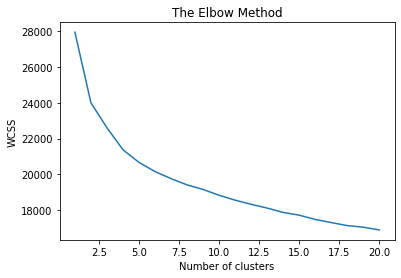

In [750]:
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(select_X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 21), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [751]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(select_X)

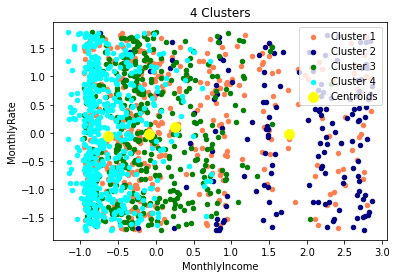

In [752]:
plt.scatter(select_X[y_kmeans == 0, 8], select_X[y_kmeans == 0, 9], s = 20, c = 'coral', label = 'Cluster 1')
plt.scatter(select_X[y_kmeans == 1, 8], select_X[y_kmeans == 1, 9], s = 20, c = 'navy', label = 'Cluster 2')
plt.scatter(select_X[y_kmeans == 2, 8], select_X[y_kmeans == 2, 9], s = 20, c = 'green', label = 'Cluster 3')
plt.scatter(select_X[y_kmeans == 3, 8], select_X[y_kmeans == 3, 9], s = 20, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 8], kmeans.cluster_centers_[:, 9], s = 100, c = 'yellow', label = 'Centroids')
plt.title('4 Clusters')
plt.xlabel('MonthlyIncome')
plt.ylabel('MonthlyRate')
plt.legend()
plt.show()

In [753]:
s = silhouette_score(select_X, kmeans.labels_)
print('Silhouette Score:', s)

Silhouette Score: 0.08720051754427798


## **Expectation Maximization**

### **EM**

In [754]:
em_ds= pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
em_ds= em_ds .drop(['PercentSalaryHike','EmployeeCount','EmployeeNumber'], axis=1) #Drop PercentSalaryHike, EmployeeCount,	EmployeeNumber
em_ds.drop(labels=['PerformanceRating'], axis=1, inplace = True)
em_ds.insert(0, 'PerformanceRating', PerformanceRating)
em_ds.head(3)# view the data

,PerformanceRating,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,3,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,1,80,0,8,0,1,6,4,0,5
1,4,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,4,80,1,10,3,3,10,7,1,7
2,3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,2,80,0,7,3,3,0,0,0,0


In [755]:
X = em_ds.iloc[:, 1:].values 
y = em_ds.iloc[:,0].values # PerformanceRating 0=>3, 1=>4
X[0],y

(array([41, 'Yes', 'Travel_Rarely', 1102, 'Sales', 1, 2, 'Life Sciences',
        2, 'Female', 94, 3, 2, 'Sales Executive', 4, 'Single', 5993, 19479,
        8, 'Y', 'Yes', 1, 80, 0, 8, 0, 1, 6, 4, 0, 5], dtype=object),
 array([3, 4, 3, ..., 4, 3, 3]))

In [756]:
# Encoding the X and Y
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,4,7,9,13,15,19,20])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
le = LabelEncoder()
y = le.fit_transform(y)
X[0],y

(array([0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0,
        0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
        0.0, 1.0, 1.0, 0.0, 1.0, 41, 1102, 1, 2, 2, 94, 3, 2, 4, 5993,
        19479, 8, 1, 80, 0, 8, 0, 1, 6, 4, 0, 5], dtype=object),
 array([0, 1, 0, ..., 1, 0, 0]))

In [757]:
sc = StandardScaler()
X = sc.fit_transform(X)
X[0],y, X.shape, y.shape

(array([-2.28090588,  2.28090588, -0.33709993, -0.48185865,  0.63984058,
        -0.21160368, -1.37405084,  1.51524392, -0.13678823,  1.19404463,
        -0.34825488, -0.67914108, -0.24305927, -0.31409347,  1.22474487,
        -1.22474487, -0.3127846 , -0.1914977 , -0.46246387, -0.27305934,
        -0.33080804, -0.23990406, -0.49787324,  1.87328654, -0.24462499,
        -0.53487311, -0.91892141,  1.45864991,  0.        , -1.59174553,
         1.59174553,  0.4463504 ,  0.74252653, -1.01090934, -0.89168825,
        -0.66053067,  1.38313827,  0.37967213, -0.05778755,  1.15325359,
        -0.10834951,  0.72601994,  2.12513592, -1.58417824,  0.        ,
        -0.93201439, -0.42164246, -2.17198183, -2.49382042, -0.16461311,
        -0.0632959 , -0.67914568,  0.24583399]),
 array([0, 1, 0, ..., 1, 0, 0]),
 (1470, 53),
 (1470,))

In [758]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(1029,) (1029, 53) (441,) (441, 53)


In [759]:
n_clusters=np.arange(2, 20)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X) 
        
        tmp_bic.append(gmm.bic(X))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

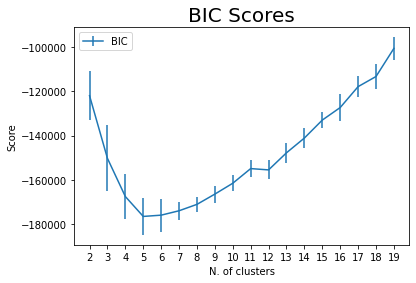

In [760]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

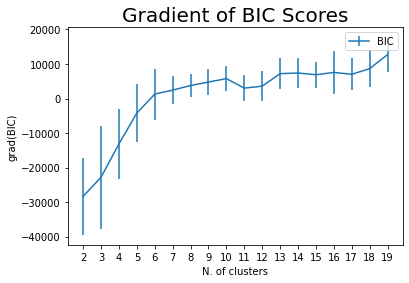

In [761]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

In [762]:
# fit model
model = GaussianMixture(n_components=5,covariance_type='tied',random_state=42)
model.fit(X)
# predict latent values
yhat = model.predict(X)

In [763]:
s = silhouette_score(X, yhat)
print('Silhouette Score:', s)

Silhouette Score: 0.08055343356591618


### **PCA - EM**

[1.07415431e-01 7.00874168e-02 5.18129226e-02 4.98581796e-02
 4.13555747e-02 4.04179809e-02 3.83274223e-02 3.55636542e-02
 3.18191931e-02 3.15814567e-02 2.90134821e-02 2.59800842e-02
 2.48637123e-02 2.39036331e-02 2.30529699e-02 2.24669135e-02
 2.23463175e-02 2.19284325e-02 2.12577688e-02 2.04421280e-02
 1.99581687e-02 1.96833623e-02 1.91720793e-02 1.88714335e-02
 1.84668805e-02 1.82309071e-02 1.81108697e-02 1.74952015e-02
 1.70972634e-02 1.57343980e-02 1.48500953e-02 1.34285744e-02
 1.09537452e-02 9.83169854e-03 9.40795306e-03 6.99313947e-03
 5.44669638e-03 4.40524828e-03 2.90969653e-03 2.18452827e-03
 1.58102524e-03 1.01268826e-03 6.79672888e-04 2.25120504e-31
 2.50620343e-32 2.31358468e-32 1.32141187e-32 9.98453052e-33
 2.42659242e-33 1.81052842e-33 1.06289842e-33 5.78872117e-34
 6.94318503e-35]


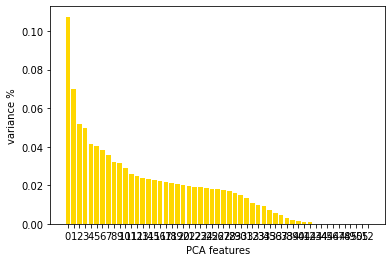

In [764]:
# Create a PCA instance: pca
pca = PCA(n_components=53)
principalComponents = pca.fit_transform(X)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='gold')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [765]:
# PCA_components.iloc[:,:30]

In [766]:
# fit model
model = GaussianMixture(n_components=5,covariance_type='tied',random_state=42)
model.fit(PCA_components.iloc[:,:30])
# predict latent values
yhat_pca = model.predict(PCA_components.iloc[:,:30])
yhat_prob_pca=model.predict_proba(PCA_components.iloc[:,:30])

In [767]:
s = silhouette_score(PCA_components.iloc[:,:30], yhat_pca)
print('Silhouette Score:', s)

Silhouette Score: 0.09712735332698234


### **ICA-EM**

In [768]:
maxlist=[]
for i in range(1,53):

  ICA = FastICA(n_components=i, random_state=42) 
  X_ica=ICA.fit_transform(X)
  model = GaussianMixture(n_components=5,covariance_type='tied',random_state=42)
  model.fit(X_ica)
  # predict latent values
  yhat_ica = model.predict(X_ica)
  yhat_prob_ica = model.predict(X_ica)
  s = silhouette_score(X_ica, yhat_ica, metric='euclidean')
  maxlist.append(s)
  print('ica:{}, Silhouette Score:{}'.format(i,s))      

maxlist.sort(reverse=True)
print(maxlist[1]) 

ica:1, Silhouette Score:0.5236455797256511
ica:2, Silhouette Score:0.3084094491270555
ica:3, Silhouette Score:0.34530634052609466
ica:4, Silhouette Score:0.36807315431812
ica:5, Silhouette Score:0.2738103626793991
ica:6, Silhouette Score:0.21804427200167753
ica:7, Silhouette Score:0.19344871061651936
ica:8, Silhouette Score:0.14507930480284462
ica:9, Silhouette Score:0.11962248546114972
ica:10, Silhouette Score:0.14047721550213085
ica:11, Silhouette Score:0.1319552537440165
ica:12, Silhouette Score:0.09989648715807689


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:13, Silhouette Score:0.10607200530036268
ica:14, Silhouette Score:0.08685330394440367
ica:15, Silhouette Score:0.07195292189203147
ica:16, Silhouette Score:0.10394250674545681
ica:17, Silhouette Score:0.07602548500101325


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:18, Silhouette Score:0.083803024185352


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:19, Silhouette Score:0.08739032414252983


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:20, Silhouette Score:0.06919845252759556
ica:21, Silhouette Score:0.058197787076971305
ica:22, Silhouette Score:0.06902276728854158


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:23, Silhouette Score:0.05928497008157322
ica:24, Silhouette Score:0.057041592839361506


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:25, Silhouette Score:0.06622780105207639


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:26, Silhouette Score:0.07323979455017562


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:27, Silhouette Score:0.0662778343321963


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:28, Silhouette Score:0.07136661678430022


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:29, Silhouette Score:0.06158674366166454


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:30, Silhouette Score:0.03488344438804198


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:31, Silhouette Score:0.022134065973325005
ica:32, Silhouette Score:0.039657782515402924
ica:33, Silhouette Score:0.050310920037207274
ica:34, Silhouette Score:0.0543499866761802
ica:35, Silhouette Score:0.06052452345702474
ica:36, Silhouette Score:0.04374932525905818


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:37, Silhouette Score:0.053641301762069306


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:38, Silhouette Score:0.04461284653233089


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:39, Silhouette Score:0.017920881176471146


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:40, Silhouette Score:0.02532641140680045


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:41, Silhouette Score:0.04958605265642575


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:42, Silhouette Score:0.045911494609384575
ica:43, Silhouette Score:0.01655667737432295


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:44, Silhouette Score:0.0479662625929132


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:45, Silhouette Score:0.012943928411024699


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:46, Silhouette Score:0.06678154431935673


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:47, Silhouette Score:0.07296174808542262


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:48, Silhouette Score:0.047897788696973045


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:49, Silhouette Score:0.06491416579709895


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:50, Silhouette Score:0.0530038147149497


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:51, Silhouette Score:0.03711574256811911


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica:52, Silhouette Score:0.038716144654616404
0.36807315431812


In [769]:
ICA = FastICA(n_components=4, random_state=42) 
X_ica=ICA.fit_transform(X)

In [770]:
model = GaussianMixture(n_components=5,covariance_type='tied',random_state=42)
model.fit(X_ica)
# predict latent values
yhat_ica = model.predict(X_ica)
yhat_prob_ica = model.predict(X_ica)

In [771]:
s = silhouette_score(X_ica, yhat_ica, metric='euclidean')
print('Silhouette Score:', s)

Silhouette Score: 0.36807315431812


Text(0, 0.5, 'ICA 2')

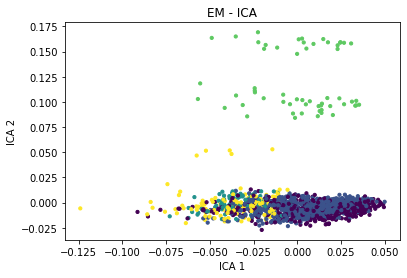

In [772]:
plt.scatter(X_ica[:, 0], X_ica[:, 1], c=yhat_ica, s=10, cmap='viridis')
plt.title('EM - ICA')
plt.xlabel("ICA 1")
plt.ylabel("ICA 2")

###**RCA-EM**

In [773]:
maxlist=[]
for i in range(1,53):
  rca = GaussianRandomProjection(n_components=i, eps=0.1, random_state=42)
  X_rca=rca.fit_transform(X)
  model = GaussianMixture(n_components=5,covariance_type='tied',random_state=42)
  model.fit(X_rca)
  # predict latent values
  yhat_rca = model.predict(X_rca)
  yhat_prob_rca = model.predict(X_rca)
  s=silhouette_score(X_rca, yhat_rca, metric='euclidean')

  maxlist.append(s)
  print('rca:{}, Silhouette Score:{}'.format(i,s))

print(max(maxlist)) 

rca:1, Silhouette Score:0.5136741441215136
rca:2, Silhouette Score:0.30182325024157247
rca:3, Silhouette Score:0.22954076552479988
rca:4, Silhouette Score:0.15676732529657944
rca:5, Silhouette Score:0.12445696327717165
rca:6, Silhouette Score:0.12564702401937733
rca:7, Silhouette Score:0.10930963049839944
rca:8, Silhouette Score:0.11460196314289907
rca:9, Silhouette Score:0.11470645732361937
rca:10, Silhouette Score:0.08975546812996803
rca:11, Silhouette Score:0.09310222261597903
rca:12, Silhouette Score:0.1070208566931625
rca:13, Silhouette Score:0.08170121054817563
rca:14, Silhouette Score:0.0954707505897646
rca:15, Silhouette Score:0.09315889323228901
rca:16, Silhouette Score:0.08756865892168111
rca:17, Silhouette Score:0.08406408925420313
rca:18, Silhouette Score:0.08699348085854915
rca:19, Silhouette Score:0.05279216766742075
rca:20, Silhouette Score:0.06597136720893683
rca:21, Silhouette Score:0.07276220997915801
rca:22, Silhouette Score:0.0689241596067042
rca:23, Silhouette Scor

In [774]:
rca = GaussianRandomProjection(n_components=2, eps=0.1, random_state=42)
X_rca=rca.fit_transform(X)

In [775]:
model = GaussianMixture(n_components=5,covariance_type='tied',random_state=42)
model.fit(X_rca)
# predict latent values
yhat_rca = model.predict(X_rca)
yhat_prob_rca = model.predict(X_rca)

In [776]:
s=silhouette_score(X_rca, yhat_rca, metric='euclidean')
print('Silhouette Score:', s)

Silhouette Score: 0.30182325024157247


Text(0, 0.5, 'RCA 2')

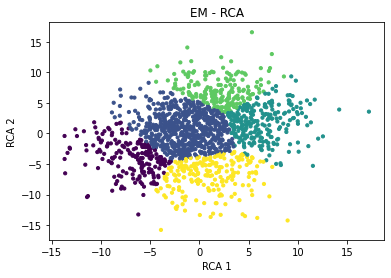

In [777]:
plt.scatter(X_rca[:, 0], X_rca[:, 1], c=yhat_rca, s=10, cmap='viridis')
plt.title('EM - RCA')
plt.xlabel("RCA 1")
plt.ylabel("RCA 2")

### **Random Forest - EM**

In [778]:
# fit model
model = GaussianMixture(n_components=5,covariance_type='tied',random_state=42)
model.fit(select_X)
# predict latent values
yhat_rf = model.predict(select_X)
yhat_prob_rf = model.predict(select_X)

In [779]:
#labels=gmm.predict(X)
s=silhouette_score(select_X, yhat_rf, metric='euclidean')
print('Silhouette Score:', s)

Silhouette Score: 0.07596634736210268


Text(0, 0.5, 'MonthlyRate')

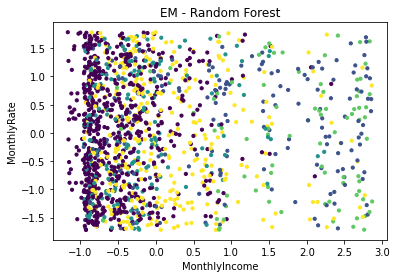

In [780]:
# plot
plt.scatter(select_X[:, 8], select_X[:, 9], c=yhat_rf, s=10, cmap='viridis')
plt.title('EM - Random Forest')
plt.xlabel('MonthlyIncome')
plt.ylabel('MonthlyRate')

### **Neural Network on Cluster Output**

In [781]:
X=np.array(yhat_prob_pca)
y=np.array(yhat_pca)

In [782]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(1029, 5)


In [783]:
#get number of columns in training data
n_cols=X_train.shape[1]

# define model 1 layers
model = Sequential()
model.add(Dense(5, input_dim=n_cols, activation='relu'))
model.add(Dense(4,  activation='relu'))
model.add(Dense(4,  activation='relu'))
model.add(Dense(5, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [784]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
9/9 [==============================] - 0s 17ms/step - loss: 0.6898 - accuracy: 0.1956 - val_loss: 0.6954 - val_accuracy: 0.1117
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.1956 - val_loss: 0.6880 - val_accuracy: 0.1117
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.1956 - val_loss: 0.6810 - val_accuracy: 0.1117
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.1956 - val_loss: 0.6744 - val_accuracy: 0.1117
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.1956 - val_loss: 0.6682 - val_accuracy: 0.1117
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.1956 - val_loss: 0.6619 - val_accuracy: 0.1117
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.1956 - val_loss: 0.6557 - val_accuracy: 0.1117
Epoch 8/100
9/9 [=========

In [785]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=1)

14/14 [==============================] - 0s 1ms/step


In [786]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
#precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
#recall = recall_score(y_test, yhat_classes)
#print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_test, yhat_classes)
#print('F1 score: %f' % f1)

Accuracy: 0.961451
Precision: 0.926298


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [787]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)

ROC AUC: 0.936041


In [788]:
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[  0   0   0   0  17]
 [  0  92   0   0   0]
 [  0   0 109   0   0]
 [  0   0   0  47   0]
 [  0   0   0   0 176]]


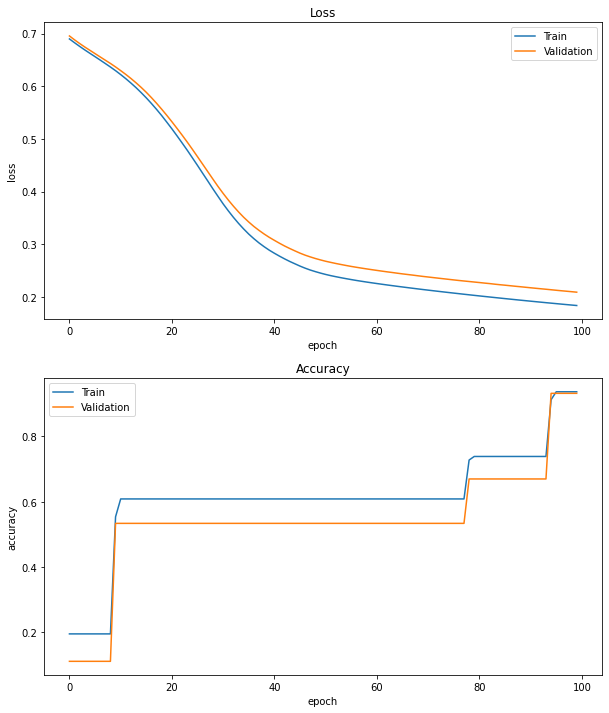

In [789]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


##**Ann-dimension-reduction**

### **Data prepard**

In [790]:
ibm_ds = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
ibm_ds = ibm_ds.drop(['PercentSalaryHike','EmployeeCount','EmployeeNumber'], axis=1) #Drop PercentSalaryHike
PerformanceRating = ibm_ds['PerformanceRating']
ibm_ds.drop(labels=['PerformanceRating'], axis=1, inplace = True)
ibm_ds.insert(0, 'PerformanceRating', PerformanceRating)
ibm_ds.head(3)# view the data

,PerformanceRating,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,3,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,1,80,0,8,0,1,6,4,0,5
1,4,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,4,80,1,10,3,3,10,7,1,7
2,3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,2,80,0,7,3,3,0,0,0,0


In [791]:
X = ibm_ds.iloc[:, 1:].values 
y = ibm_ds.iloc[:,0].values # PerformanceRating 0=>3, 1=>4
X[0],y

(array([41, 'Yes', 'Travel_Rarely', 1102, 'Sales', 1, 2, 'Life Sciences',
        2, 'Female', 94, 3, 2, 'Sales Executive', 4, 'Single', 5993, 19479,
        8, 'Y', 'Yes', 1, 80, 0, 8, 0, 1, 6, 4, 0, 5], dtype=object),
 array([3, 4, 3, ..., 4, 3, 3]))

In [792]:
# Encoding the X and Y
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,4,7,9,13,15,19,20])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)

In [793]:
sc = StandardScaler()
X = sc.fit_transform(X)
X[0],y, X.shape, y.shape

(array([-2.28090588,  2.28090588, -0.33709993, -0.48185865,  0.63984058,
        -0.21160368, -1.37405084,  1.51524392, -0.13678823,  1.19404463,
        -0.34825488, -0.67914108, -0.24305927, -0.31409347,  1.22474487,
        -1.22474487, -0.3127846 , -0.1914977 , -0.46246387, -0.27305934,
        -0.33080804, -0.23990406, -0.49787324,  1.87328654, -0.24462499,
        -0.53487311, -0.91892141,  1.45864991,  0.        , -1.59174553,
         1.59174553,  0.4463504 ,  0.74252653, -1.01090934, -0.89168825,
        -0.66053067,  1.38313827,  0.37967213, -0.05778755,  1.15325359,
        -0.10834951,  0.72601994,  2.12513592, -1.58417824,  0.        ,
        -0.93201439, -0.42164246, -2.17198183, -2.49382042, -0.16461311,
        -0.0632959 , -0.67914568,  0.24583399]),
 array([0, 1, 0, ..., 1, 0, 0]),
 (1470, 53),
 (1470,))

###**PCA**

[1.07415431e-01 7.00874168e-02 5.18129226e-02 4.98581796e-02
 4.13555747e-02 4.04179809e-02 3.83274223e-02 3.55636542e-02
 3.18191931e-02 3.15814567e-02 2.90134821e-02 2.59800842e-02
 2.48637123e-02 2.39036331e-02 2.30529699e-02 2.24669135e-02
 2.23463175e-02 2.19284325e-02 2.12577688e-02 2.04421280e-02
 1.99581687e-02 1.96833623e-02 1.91720793e-02 1.88714335e-02
 1.84668805e-02 1.82309071e-02 1.81108697e-02 1.74952015e-02
 1.70972634e-02 1.57343980e-02 1.48500953e-02 1.34285744e-02
 1.09537452e-02 9.83169854e-03 9.40795306e-03 6.99313947e-03
 5.44669638e-03 4.40524828e-03 2.90969653e-03 2.18452827e-03
 1.58102524e-03 1.01268826e-03 6.79672888e-04 2.25120504e-31
 2.50620343e-32 2.31358468e-32 1.32141187e-32 9.98453052e-33
 2.42659242e-33 1.81052842e-33 1.06289842e-33 5.78872117e-34
 6.94318503e-35]


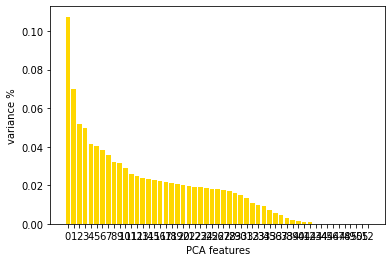

In [794]:
pca = PCA(n_components=53)
principalComponents = pca.fit_transform(X)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='gold')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [795]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(PCA_components.iloc[:,:31], y, test_size=0.3, random_state=42)

In [796]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(1029, 2)


In [797]:
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 2 layers
model = Sequential()
model.add(Dense(30, input_dim=n_cols, activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [798]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
9/9 [==============================] - 0s 21ms/step - loss: 0.7826 - accuracy: 0.5893 - val_loss: 0.6866 - val_accuracy: 0.7282
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.6780 - val_loss: 0.6271 - val_accuracy: 0.7913
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.7315 - val_loss: 0.5848 - val_accuracy: 0.8301
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5991 - accuracy: 0.7849 - val_loss: 0.5547 - val_accuracy: 0.8398
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5685 - accuracy: 0.8177 - val_loss: 0.5299 - val_accuracy: 0.8495
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5441 - accuracy: 0.8299 - val_loss: 0.5083 - val_accuracy: 0.8592
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5235 - accuracy: 0.8360 - val_loss: 0.4896 - val_accuracy: 0.8592
Epoch 8/100
9/9 [=========

In [799]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

14/14 [==============================] - 0s 1ms/step


In [800]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.839002
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


In [801]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.537727
[[370   9]
 [ 62   0]]


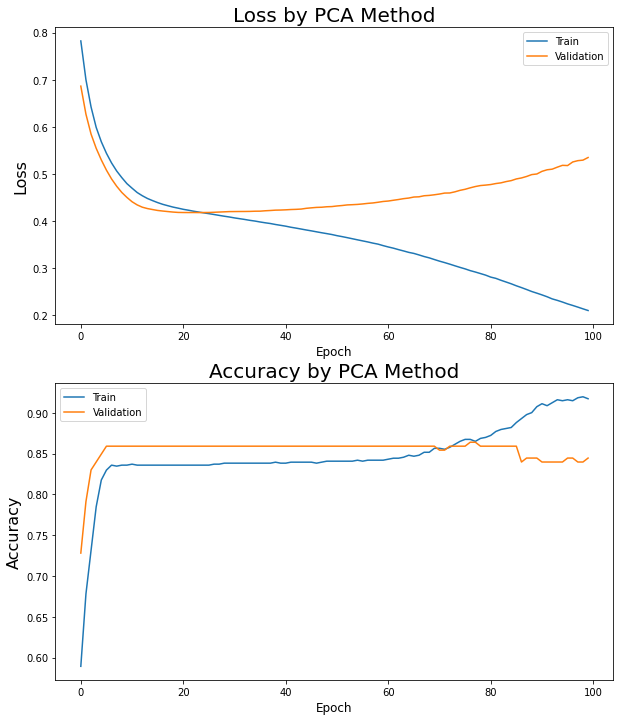

In [802]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss by PCA Method', fontsize=20)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy by PCA Method', fontsize=20)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()

###**RCA**

In [803]:
rca = GaussianRandomProjection(n_components=2, eps=0.1, random_state=42)
X_rca=rca.fit_transform(X)

In [804]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_rca, y, test_size=0.3, random_state=42)

In [805]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(1029, 2)


In [806]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(2, input_dim=n_cols, activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [807]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
9/9 [==============================] - 0s 16ms/step - loss: 0.6116 - accuracy: 0.8360 - val_loss: 0.5843 - val_accuracy: 0.8592
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5978 - accuracy: 0.8360 - val_loss: 0.5709 - val_accuracy: 0.8592
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5860 - accuracy: 0.8360 - val_loss: 0.5605 - val_accuracy: 0.8592
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5763 - accuracy: 0.8360 - val_loss: 0.5510 - val_accuracy: 0.8592
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5675 - accuracy: 0.8360 - val_loss: 0.5422 - val_accuracy: 0.8592
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5594 - accuracy: 0.8360 - val_loss: 0.5346 - val_accuracy: 0.8592
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5521 - accuracy: 0.8360 - val_loss: 0.5282 - val_accuracy: 0.8592
Epoch 8/100
9/9 [=========

In [808]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

14/14 [==============================] - 0s 992us/step


In [809]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.859410
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [810]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.538620
[[379   0]
 [ 62   0]]


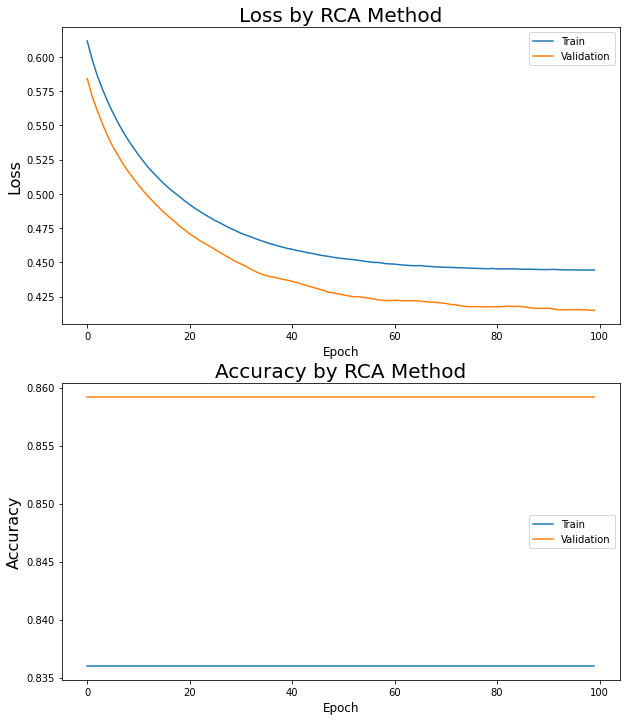

In [811]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss by RCA Method', fontsize=20)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy by RCA Method', fontsize=20)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()

###**ICA**

In [812]:
ICA = FastICA(n_components=4, random_state=42) 
X_ica=ICA.fit_transform(X)

In [813]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_ica, y, test_size=0.3, random_state=42)

In [814]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(1029, 2)


In [815]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(4, input_dim=n_cols, activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [816]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
9/9 [==============================] - 0s 16ms/step - loss: 0.6914 - accuracy: 0.7655 - val_loss: 0.6881 - val_accuracy: 0.8592
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.8360 - val_loss: 0.6816 - val_accuracy: 0.8592
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.8360 - val_loss: 0.6740 - val_accuracy: 0.8592
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.8360 - val_loss: 0.6660 - val_accuracy: 0.8592
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.8360 - val_loss: 0.6575 - val_accuracy: 0.8592
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.8360 - val_loss: 0.6480 - val_accuracy: 0.8592
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.8360 - val_loss: 0.6382 - val_accuracy: 0.8592
Epoch 8/100
9/9 [=========

In [817]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

14/14 [==============================] - 0s 1ms/step


In [818]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.859410
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [819]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.539706
[[379   0]
 [ 62   0]]


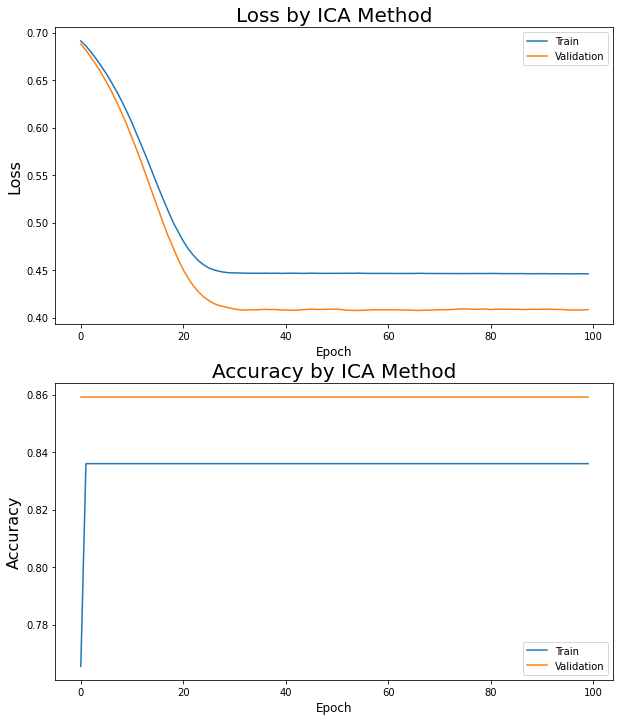

In [820]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss by ICA Method', fontsize=20)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy by ICA Method', fontsize=20)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()

###**Feature Selection - Random Forest**

In [821]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(select_X, y, test_size=0.3, random_state=42)

In [822]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(1029, 2)


In [823]:
select_X.shape

(1470, 19)

In [824]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(19, input_dim=n_cols, activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(6,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [825]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Epoch 1/100
9/9 [==============================] - 0s 17ms/step - loss: 0.6547 - accuracy: 0.7643 - val_loss: 0.6313 - val_accuracy: 0.8252
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.8165 - val_loss: 0.6054 - val_accuracy: 0.8495
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.8262 - val_loss: 0.5792 - val_accuracy: 0.8544
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5862 - accuracy: 0.8299 - val_loss: 0.5524 - val_accuracy: 0.8544
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5636 - accuracy: 0.8360 - val_loss: 0.5260 - val_accuracy: 0.8592
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5412 - accuracy: 0.8360 - val_loss: 0.5018 - val_accuracy: 0.8592
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.5205 - accuracy: 0.8360 - val_loss: 0.4787 - val_accuracy: 0.8592
Epoch 8/100
9/9 [=========

In [826]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

14/14 [==============================] - 0s 903us/step


In [827]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.859410
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [828]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.421993
[[379   0]
 [ 62   0]]


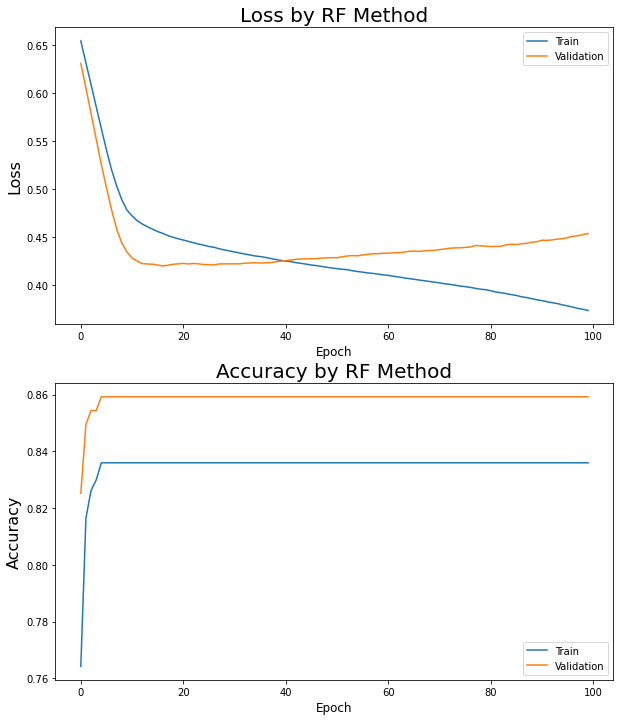

In [829]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss by RF Method', fontsize=20)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy by RF Method', fontsize=20)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.show()